<a href="https://colab.research.google.com/github/yousufkhanyk/COVID-19/blob/main/COVID_19yk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# COVID_19

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#  COVID dataset
df = pd.read_csv("/content/drive/MyDrive/student performance/covid19_country_wise_latest.csv")


In [ ]:

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:\n", df.isnull().sum())
print("\nColumns:\n", df.columns.tolist())

Dataset Shape: (187, 15)

First few rows:
  Country/Region  Confirmed  Deaths  Recovered  Active  New cases  New deaths  \
0    Afghanistan      36263    1269      25198    9796        106          10   
1        Albania       4880     144       2745    1991        117           6   
2        Algeria      27973    1163      18837    7973        616           8   
3        Andorra        907      52        803      52         10           0   
4         Angola        950      41        242     667         18           1   

   New recovered  Deaths / 100 Cases  Recovered / 100 Cases  \
0             18                3.50                  69.49   
1             63                2.95                  56.25   
2            749                4.16                  67.34   
3              0                5.73                  88.53   
4              0                4.32                  25.47   

   Deaths / 100 Recovered  Confirmed last week  1 week change  \
0                    5.04  

In [ ]:
# Classify countries into High Deaths (>= median) vs Low Deaths (< median)
median_deaths = df["Deaths"].median()
df["High_Deaths"] = (df["Deaths"] >= median_deaths).astype(int)

# Features (drop categorical + target column)
X = df.drop(columns=["Country/Region", "WHO Region", "High_Deaths"])
X = X.select_dtypes(include=[np.number])  # keep numeric only
y = df["High_Deaths"]

yk

/tmp/ipython-input-287731258.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="High_Deaths", palette="Set2")


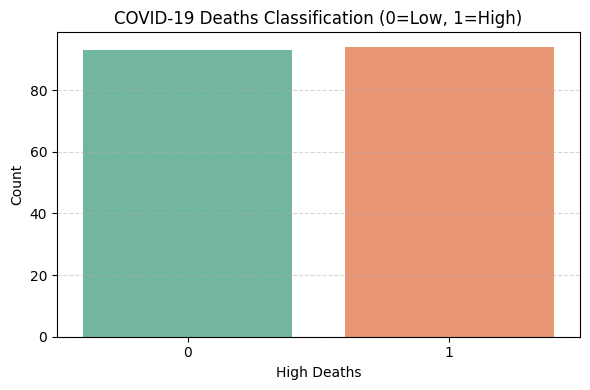

In [ ]:
# Class Balance Plot

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="High_Deaths", palette="Set2")
plt.title("COVID-19 Deaths Classification (0=Low, 1=High)")
plt.xlabel("High Deaths")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Train-Test Split
# --------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Random Forest Classifier
# --------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

# Handle potential infinite values or values too large for float32
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with a large number if necessary, or consider imputation
# For simplicity, I'll fill with a large number. You might want to use a more sophisticated imputer.
X_train = np.nan_to_num(X_train, nan=1e9, posinf=1e9, neginf=-1e9)
X_test = np.nan_to_num(X_test, nan=1e9, posinf=1e9, neginf=-1e9)


rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Random Forest Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


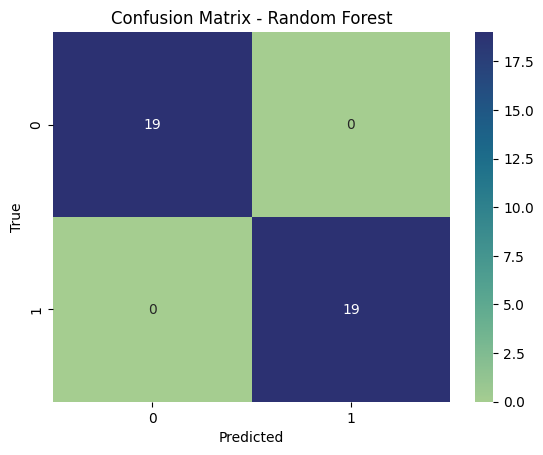

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

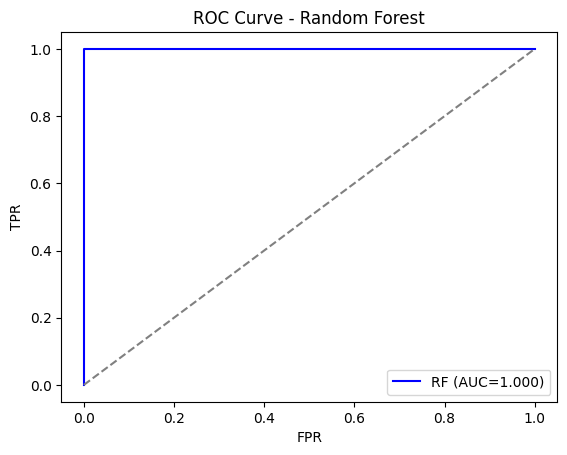

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f"RF (AUC={roc_auc_score(y_test, y_prob_rf):.3f})", color="blue")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

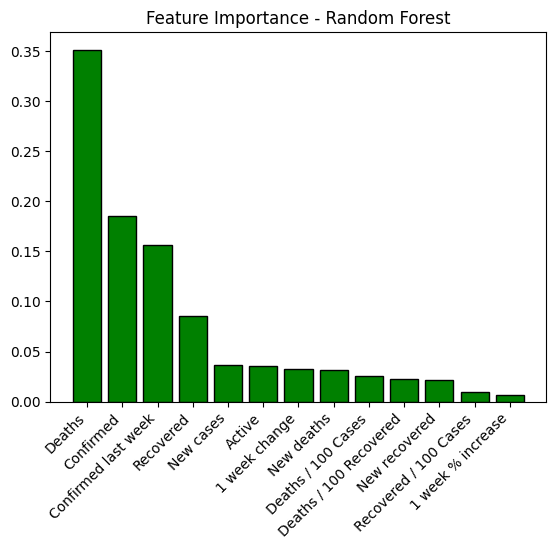

In [ ]:
# Feature Importance
importances = rf_model.feature_importances_
features = X.columns  # Use columns from the original DataFrame X
indices = np.argsort(importances)[::-1]
plt.bar(range(len(features)), importances[indices], align="center", color="green", edgecolor="black")
plt.xticks(range(len(features)), features[indices], rotation=45, ha="right")
plt.title("Feature Importance - Random Forest")
plt.show()

In [ ]:
# KNN Classifier

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

print("\n=== KNN Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn))


=== KNN Metrics ===
Accuracy: 0.7894736842105263
Precision: 0.8235294117647058
Recall: 0.7368421052631579
F1 Score: 0.7777777777777778
ROC AUC: 0.8698060941828254


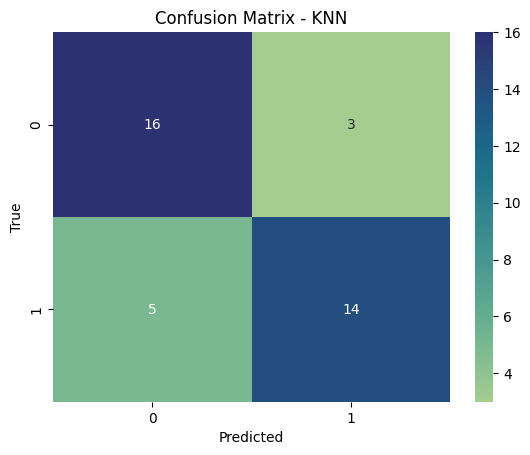

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

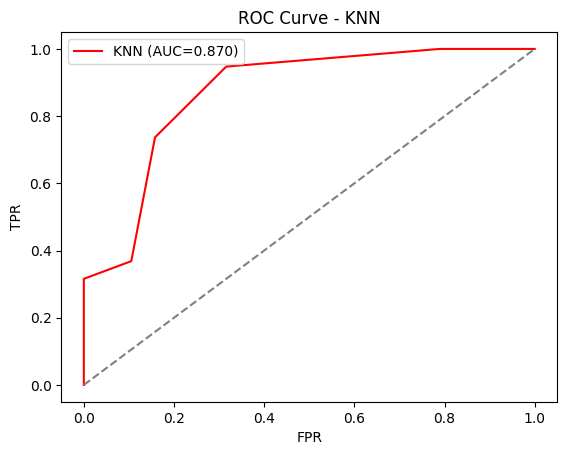

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
plt.plot(fpr, tpr, label=f"KNN (AUC={roc_auc_score(y_test, y_prob_knn):.3f})", color="red")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - KNN")
plt.legend()
plt.show()

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    criterion="gini",
    class_weight="balanced",
    random_state=42
)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

print("\n=== Decision Tree Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_dt))


=== Decision Tree Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


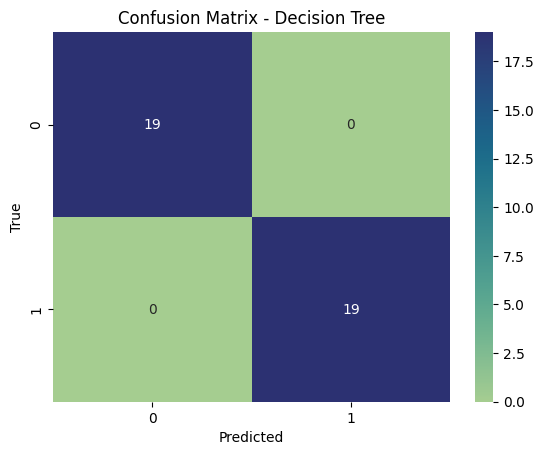

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


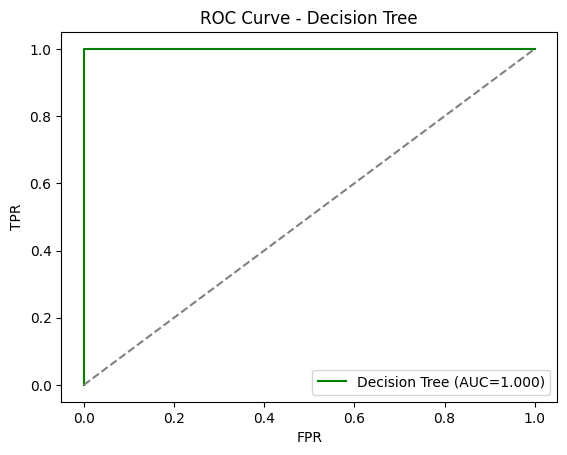

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC={roc_auc_score(y_test, y_prob_dt):.3f})", color="green")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()

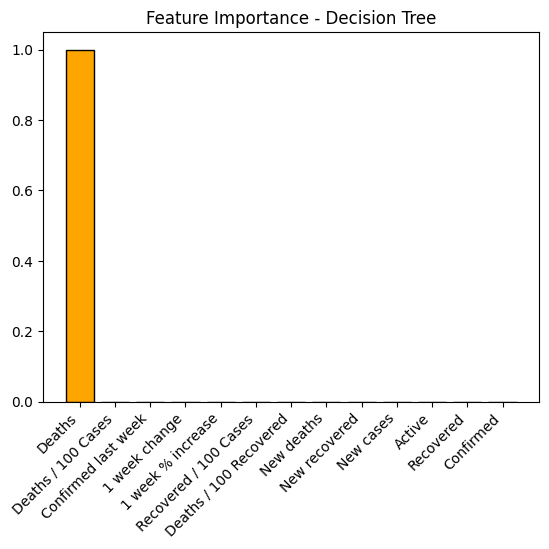

In [ ]:
# Feature Importance (Decision Tree)
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(features)), importances[indices], align="center", color="orange", edgecolor="black")
plt.xticks(range(len(features)), features[indices], rotation=45, ha="right")
plt.title("Feature Importance - Decision Tree")
plt.show()

yk